# Machine Learning Tests

## Setup

In [1]:
import mne
import re
import os
import numpy as np
import source_localization as srcl
import MEG_analysis as meg
import machine_learning as ml
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression, LinearRegression

from scipy.io import loadmat

from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator
from mne.decoding import (cross_val_multiscore, LinearModel, SlidingEstimator,
                          get_coef, Vectorizer, Scaler)

%matplotlib inline

In [2]:
folder_dict = meg.get_folder_dict()
subj = 'MF-aligned'
meg_dir = '../../../../MEG_raw01/170131_fujita_SD'
should_save_evoked_figs = False
should_train_model = True
source_localization_dir = "/usr/local/freesurfer/subjects"

In [3]:
epochs, evoked = meg.get_processed_meg_data(subj, folder_dict, meg_dir)
src, bem = srcl.get_processed_mri_data(subj, source_localization_dir)
cov = mne.compute_covariance(epochs, tmax=0., method=['shrunk', 'empirical'], rank=None, verbose=True)
fwd = srcl.make_forward_sol(evoked, src, bem, "%s/%s-trans.fif" % (meg_dir, subj))

Reading ../Data/Epochs/MF-aligned-epo.fif ...
    Read a total of 10 projection items:
        grad_68_noIAS_20140702-2.fif : PCA-v1 (1 x 360) active
        grad_68_noIAS_20140702-2.fif : PCA-v2 (1 x 360) active
        grad_68_noIAS_20140702-2.fif : PCA-v3 (1 x 360) active
        grad_68_noIAS_20140702-2.fif : PCA-v4 (1 x 360) active
        grad_68_noIAS_20140702-2.fif : PCA-v5 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v1 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v2 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v3 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v4 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v5 (1 x 360) active
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
600 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 5)
10 project

In [4]:
def calc_accuracy(y_pred, y_test):
    total = 0
    for i in range(len(y_pred)):
        if y_pred[i] == y_test[i]:
            total+=1

    return total / len(y_pred)

In [4]:
def generate_y(n_classes=2):
    y = []
    for i in range(6):
        y_path = "../../../../MEG/Behaviour/07fujita0131/fujita0131_session_20170131T145759_block%s_data.mat" % (i + 1)
        y += ml.generate_y_classes(y_path, n_classes)
        
    y = np.array(y)
    return y

## RNN model

### Initialize Train, Test Data

In [5]:
inv_op_epoch = mne.minimum_norm.make_inverse_operator(epochs.info, fwd, cov, loose=0.2, depth=0.8)
stc_epoch = mne.minimum_norm.apply_inverse_epochs(epochs, inv_op_epoch, 0.11, return_generator=True)

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 204 channels.
    204 out of 204 channels remain after picking
Selected 204 channels
Creating the depth weighting matrix...
    204 planar channels
    limit = 7955/8196 = 10.006844
    scale = 1.91128e-08 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 5)
Computing rank from covariance with rank=None
    Using tolerance 8.4e-14 (2.2e-16 eps * 204 dim * 1.9  max singular value)
    Estimated rank (grad): 199
    GRAD: rank 199 computed from 204 data channels with 5 projectors
    Setting small GRAD eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weig

In [6]:
X = np.einsum('ikj->ijk', np.array([next(stc_epoch).crop(0, 0.4, False).bin(0.025).data for i in range(600)]))
X_train, X_test = X[:500], X[500:]
del stc_epoch
del X
print(X.shape)

ng the current components...
Processing epoch : 294 / 600
combining the current components...
Processing epoch : 295 / 600
combining the current components...
Processing epoch : 296 / 600
combining the current components...
Processing epoch : 297 / 600
combining the current components...
Processing epoch : 298 / 600
combining the current components...
Processing epoch : 299 / 600
combining the current components...
Processing epoch : 300 / 600
combining the current components...
Processing epoch : 301 / 600
combining the current components...
Processing epoch : 302 / 600
combining the current components...
Processing epoch : 303 / 600
combining the current components...
Processing epoch : 304 / 600
combining the current components...
Processing epoch : 305 / 600
combining the current components...
Processing epoch : 306 / 600
combining the current components...
Processing epoch : 307 / 600
combining the current components...
Processing epoch : 308 / 600
combining the current components

In [ ]:
y = generate_y(n_classes=0)
y_train, y_test = y[:500], y[500:]

### Train model with RNN

In [8]:
model = ml.RNNModel(n_epochs=20)
model.fit(X_train, y_train)

Epoch 1/20


TypeError: in user code:

    /home/whitney/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /media/whitney/New Volume/Yuki/MNE_analysis/honors-thesis/honors-thesis/code/machine_learning.py:28 gabor_loss  *
        cos_diff_orig = K.cos(2 * np.pi * (y_pred / 360)) - K.cos(2 * np.pi * (y_true / 360))
    /home/whitney/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:1140 binary_op_wrapper
        raise e
    /home/whitney/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:1124 binary_op_wrapper
        return func(x, y, name=name)
    /home/whitney/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/whitney/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:526 subtract
        return gen_math_ops.sub(x, y, name)
    /home/whitney/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gen_math_ops.py:10466 sub
        "Sub", x=x, y=y, name=name)
    /home/whitney/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:506 _apply_op_helper
        inferred_from[input_arg.type_attr]))

    TypeError: Input 'y' of 'Sub' Op has type float64 that does not match type float32 of argument 'x'.


### Evaluate Performance

In [11]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.round(y_pred.T[0])
accuracy = calc_accuracy(y_pred, y_test)
print(accuracy)
print(y_pred)
print(y_test)

4/4 [==============================] - 0s 8ms/step - loss: 0.5494 - accuracy: 0.0100
0.0
[ -8. -12. -12. -12. -16.  -9. -11.  -7. -13. -12.  -8.  -9. -12. -14.
 -12. -14.  -4. -11. -10. -14.  -8. -10.  -7. -11.  -9.  -9. -10.  -8.
 -13. -12. -13.  -8. -10. -16.  -7. -12. -11. -15.  -7. -12.  -9. -10.
  -8.  -6. -12. -11.  -8.  -9. -12. -12. -12.  -9.  -8. -12.  -3.  -9.
 -10. -10. -11. -12. -13. -16. -10.  -7.  -9. -13.  -9. -13.  -6.  -8.
 -10. -12. -11. -14. -11. -12.  -8. -12.  -8.  -9.  -7.  -8. -11. -13.
 -13.  -5. -10. -11. -13. -10. -13.  -8. -12.  -9. -10.  -9. -10. -11.
  -5.  -5.]
[-17  47 -83 -57 -88   3   4  42  70  28 -39  20 -37 -62 -26  16  46 -68
  58 -77  62  34 -55  -2  19  22  -2 -74 -80  24  61 -74  53   0 -56  64
  66 -34 -14   7 -53  23  34  33 -30 -14 -32  70 -13  73  -7 -44 -67 -20
  31 -68  81 -18  84   7 -90 -14 -77 -37 -87 -66 -30  71 -79 -45 -57  42
 -80 -35 -25  17  -9  71 -43 -36  -8  74  22  81   2 -74  33  50 -86  43
  26   3 -68  80 -46 -74  11  21  21 

## Train mne model

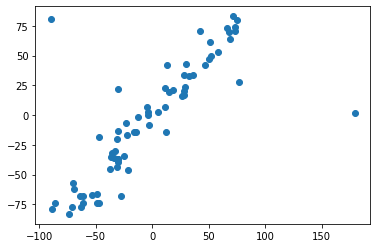

In [9]:
data = loadmat("../../../../MEG/Behaviour/07fujita0131/fujita0131_session_20170131T145759_block6_data.mat")
response = data["GabOrSpec"]
target = data["TargetGabor"]

plt.scatter(response, target)

In [20]:
inv_op_epoch = mne.minimum_norm.make_inverse_operator(epochs.info, fwd, cov, loose=0.2, depth=0.8)
stc_epoch = mne.minimum_norm.apply_inverse_epochs(epochs, inv_op_epoch, 0.11, return_generator=True)

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 204 channels.
    204 out of 204 channels remain after picking
Selected 204 channels
Creating the depth weighting matrix...
    204 planar channels
    limit = 7955/8196 = 10.006844
    scale = 1.91128e-08 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 5)
Computing rank from covariance with rank=None
    Using tolerance 8.4e-14 (2.2e-16 eps * 204 dim * 1.9  max singular value)
    Estimated rank (grad): 199
    GRAD: rank 199 computed from 204 data channels with 5 projectors
    Setting small GRAD eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weig

In [21]:
X = np.array([next(stc_epoch).crop(0, 0.4).bin(0.025).lh_data for i in range(600)])
X_train, X_test = X[:500], X[500:]
del stc_epoch
del X
print(X.shape)

ng the current components...
Processing epoch : 294 / 600
combining the current components...
Processing epoch : 295 / 600
combining the current components...
Processing epoch : 296 / 600
combining the current components...
Processing epoch : 297 / 600
combining the current components...
Processing epoch : 298 / 600
combining the current components...
Processing epoch : 299 / 600
combining the current components...
Processing epoch : 300 / 600
combining the current components...
Processing epoch : 301 / 600
combining the current components...
Processing epoch : 302 / 600
combining the current components...
Processing epoch : 303 / 600
combining the current components...
Processing epoch : 304 / 600
combining the current components...
Processing epoch : 305 / 600
combining the current components...
Processing epoch : 306 / 600
combining the current components...
Processing epoch : 307 / 600
combining the current components...
Processing epoch : 308 / 600
combining the current components

In [ ]:
y = generate_y(n_classes=0)
y_train, y_test = y[:500], y[500:]

In [31]:
# prepare a series of classifier applied at each time sample
clf = make_pipeline(StandardScaler(),  # z-score normalization
                    #SelectKBest(f_classif, k=4000),  # select features for speed
                    LinearModel(LogisticRegression(C=0.5, solver='saga', l1_ratio=0.6, penalty='elasticnet')))
time_decod = SlidingEstimator(clf, scoring='roc_auc')

scores = cross_val_multiscore(time_decod, X_train, y_train, cv=5, n_jobs=1)

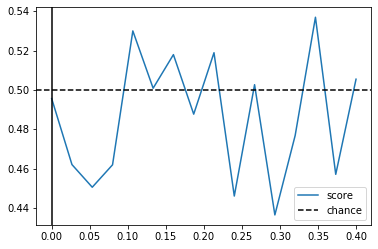

In [32]:
# Plot average decoding scores of 5 splits
fig, ax = plt.subplots(1)
ax.plot(np.linspace(0, 0.4, 16), scores.mean(0), label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.axvline(0, color='k')
plt.legend()
plt.show()

In [33]:
time_decod.fit(X_train, y_train)

<SlidingEstimator(base_estimator=Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linearmodel',
                 LinearModel(model=LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
        ...lver='saga', tol=0.0001, verbose=0,
                   warm_start=False)))],
         verbose=False),
         n_jobs=1, scoring='roc_auc', verbose=None, fitted with 16 estimators>

In [42]:
y_pred = time_decod.predict(X_test)
accuracy_lst = [calc_accuracy(y_pred[:, i], y_test) for i in range(16)]
print(max(accuracy_lst))


0.8125


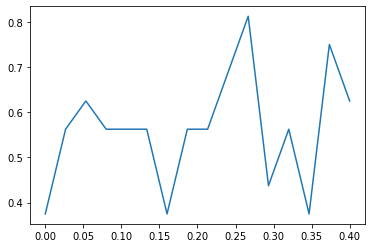

In [44]:
plt.plot(np.linspace(0, 0.4, 16), accuracy_lst)

## Test with just epochs data

In [21]:
epochs, evoked = meg.get_processed_meg_data(subj, folder_dict, meg_dir)

Reading ../Data/Epochs/MF-aligned-epo.fif ...
    Read a total of 10 projection items:
        grad_68_noIAS_20140702-2.fif : PCA-v1 (1 x 360) active
        grad_68_noIAS_20140702-2.fif : PCA-v2 (1 x 360) active
        grad_68_noIAS_20140702-2.fif : PCA-v3 (1 x 360) active
        grad_68_noIAS_20140702-2.fif : PCA-v4 (1 x 360) active
        grad_68_noIAS_20140702-2.fif : PCA-v5 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v1 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v2 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v3 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v4 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v5 (1 x 360) active
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
600 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 5)
10 project

In [18]:
def get_y():
    y = []
    for i in range(6):
        y_path = "../../../../MEG/Behaviour/07fujita0131/fujita0131_session_20170131T145759_block%s_data.mat" % (i + 1)
        y += ml.classify_target_gabors(y_path)
        
    y = np.array(y)
    return y

In [22]:
epochs.resample(80)
print(epochs.get_data().shape)

(600, 210, 120)


In [25]:
labels = epochs.events[:, -1]
meg_epochs = epochs.copy().pick_types(meg=True, eeg=False).crop(0, 0.4, False)
meg_data = meg_epochs.get_data().reshape(len(labels), -1)
#clf = LogisticRegression(penalty="elasticnet", solver='saga', l1_ratio=0.5, C=0.05, max_iter=25)
clf = LinearRegression()
scaler = StandardScaler()

model = clf

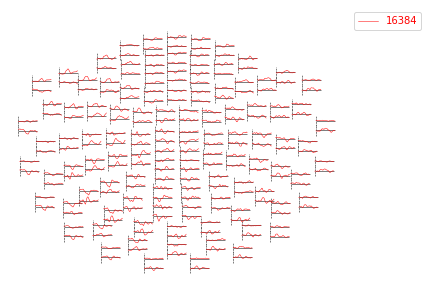

In [26]:
check_evoked = meg_epochs.average()
check_evoked.pick_types('grad').plot_topo(color='r')
plt.show()

In [27]:
y = get_y()
#X = scaler.fit_transform(meg_data)
X = meg_data

X_test, y_test = X[550:], y[550:]
X, y = X[:550], y[:550]

print(X_test.shape)
print(y_test.shape)
print(X.shape)
print(y.shape)

(50, 6528)
(50,)
(550, 6528)
(550,)


In [28]:
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

0.01090909090909091
[-4.80000000e+01  6.10000000e+01 -8.20000000e+01 -1.00000000e+01
  2.80000000e+01  2.40000000e+01 -4.10000000e+01  8.50000000e+01
  6.10000000e+01 -8.60000000e+01  2.60000000e+01  3.20000000e+01
  7.40000000e+01  8.50000000e+01  2.70000000e+01  1.80000000e+01
 -6.70000000e+01 -5.60000000e+01  8.20000000e+01 -6.10000000e+01
  9.00000000e+01  5.40000000e+01  1.20000000e+01 -7.90000000e+01
 -2.10000000e+01 -2.30000000e+01  7.10000000e+01 -8.80000000e+01
  4.10000000e+01  9.00000000e+00  4.20000000e+01  1.90000000e+01
 -2.20000000e+01 -6.00000000e+01 -7.40000000e+01  2.00000000e+00
  4.70000000e+01 -5.80000000e+01  1.00000000e+00 -3.80000000e+01
  9.00000000e+01 -4.50000000e+01 -7.80000000e+01  6.20000000e+01
 -3.00000000e+01 -1.20000000e+01 -8.10000000e+01 -1.00000000e+00
 -5.00000000e+01 -1.70000000e+01  5.30000000e+01  3.80000000e+01
 -1.40000000e+01  7.40000000e+01  2.50000000e+01 -3.90000000e+01
  5.40000000e+01 -8.30000000e+01 -3.00000000e+01  1.30000000e+01
 -7.4

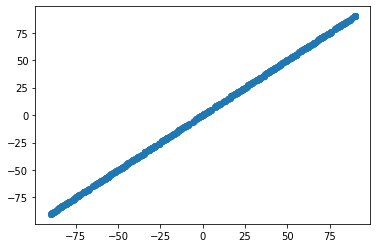

In [31]:
y_pred = model.predict(X)
accuracy = calc_accuracy(y_pred, y)
print(accuracy)
print(y_pred)
print(y_test)
plt.scatter(y_pred, y)

In [33]:
y_pred2 = model.predict(X)
accuracy = calc_accuracy(y_pred2, y)
print(accuracy)

0.0036363636363636364


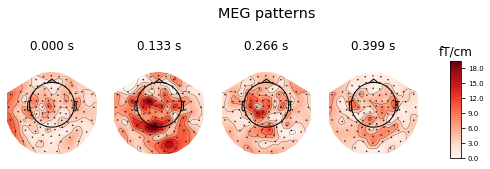

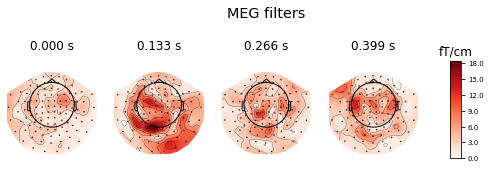

In [43]:
for name, coef in (('patterns', model.patterns_), ('filters', model.filters_)):
    # We fitted the linear model onto Z-scored data. To make the filters
    # interpretable, we must reverse this normalization step
    coef = scaler.inverse_transform([coef])[0]

    # The data was vectorized to fit a single model across all time points and
    # all channels. We thus reshape it:
    coef = coef.reshape(len(meg_epochs.ch_names), -1)

    # Plot
    meg_evoked = mne.EvokedArray(coef, meg_epochs.info, tmin=0)
    meg_evoked.plot_topomap(title='MEG %s' % name, time_unit='s')

## Compare topomaps between conditions